In [1]:
import os

from PIL import Image

import numpy as np
import random

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython import display

In [2]:
# Settings
x_range = [-10, 10]
x_reshape = [-1, 1]
x_samples = 500

nn_samp_range = int(x_samples * 0.4)
nn_start_idx = np.random.randint(0, x_samples-nn_samp_range)
nn_samples = int(x_samples * 0.1)

max_plots = 20
gif_fps = 5

num_in_nodes = 1
num_out_nodes = 1

train_seed = 123
nn_lr = 1e-3
loss_th = 1e-5

activation = nn.Sigmoid
# activation = nn.Tanh
# activation = nn.Mish

# Generate the data from Analytical Solution
scale_ind = 1
shift_ind = 0
scale_dep = 1
shift_dep = 0

In [3]:
# Save a gif file
def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)    

In [4]:
def plot_result(x, y, x_data, y_data, yh, xp=None):
   
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
   
    plt.plot(x,y, color="grey", linewidth=3, alpha=0.5, label="Exact solution")
   
    plt.plot(x,yh, color="tab:blue", linewidth=1, linestyle='dashed', alpha=1.0, label="Neural network prediction")
   
    if x_data is not None:
        plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.75, label='Training data')
       
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=20, color="tab:green", alpha=0.75,
                    label='Physics loss training locations')
   
    l = plt.legend(loc='best', frameon=False, fontsize="large")
   
    plt.setp(l.get_texts(), color="k")
    
#     plt.xlim(-0.05, 1.05)
#     plt.ylim(min(y)-0.1*abs(max(y)), max(y) + 0.1*abs(max(y)))
   
    plt.text(1.065,0.7*max(y),"Training step: %i"%(i+1),fontsize="xx-large",color="k")
   
    plt.axis("off")

In [5]:
# Fully Connected Network (FCN) for Training
class FCN(nn.Module):
    
    def __init__(self, N_INPUT, N_OUTPUT):
        
        super().__init__()
        
        # Input Layer
        self.fcn = nn.Sequential(*[nn.Linear(N_INPUT, N_OUTPUT), activation()])
        
    def forward(self, x):
        x = self.fcn(x)
        return x    

In [6]:
# Create a Sigmoid Function
def create_sigmoid(x, scale_dep, shift_dep, scale_ind, shift_ind):
    lin_eq = scale_ind*x + shift_ind
    y = (scale_dep / (1 + np.exp(-lin_eq))) + shift_dep
    return y

In [7]:
# Sampling Points
input_idxs = range(nn_start_idx, nn_start_idx+nn_samp_range)

# Uniform Sampling
train_idxs = np.linspace(0, x_samples-1, nn_samples).astype('int')

# Create the directory to store images
if not os.path.exists('epoch_plots'):
    os.mkdir('epoch_plots')    

In [8]:
x_exact = torch.linspace(x_range[0], x_range[1], x_samples).view(x_reshape[0],x_reshape[1])
y_ref = create_sigmoid(x_exact, 1, 0, 1, 0).view(x_reshape[0],x_reshape[1])
y_exact = create_sigmoid(x_exact, scale_dep, shift_dep, scale_ind, shift_ind).view(x_reshape[0],x_reshape[1])

In [9]:
# Slice out a small number of points
x_data = x_exact[train_idxs]
y_data = y_exact[train_idxs]

In [10]:
sig_eq = r"f(x) = ${\frac{%d} {1+e^{-%dx-%d}}} + %d$" % (scale_dep, scale_ind, shift_ind, shift_dep)

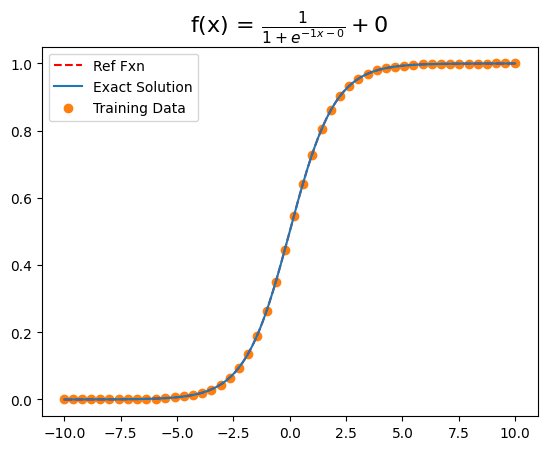

In [11]:
# Plot the original and modified functions
plt.figure()
plt.plot(x_exact, y_ref, c='r', ls='dashed', label='Ref Fxn')
plt.plot(x_exact, y_exact, label='Exact Solution')
plt.scatter(x_data, y_data, color='tab:orange', label="Training Data")

plt.title(sig_eq, fontsize=16)
plt.legend()
plt.show()

In [12]:
# Train the NN to fit the data
torch.manual_seed(train_seed)

num_epochs = 50000
loss_scale = 10000

plot_freq = int(num_epochs/max_plots)

In [13]:
# Create the model
model = FCN(num_in_nodes, num_out_nodes)

# Assign an Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=nn_lr)

In [14]:
# Train the model
files_nn = []
for i in range(num_epochs):
    
    plot_img = False
    stop_training = False
    
    optimizer.zero_grad()
    yp_data = model(x_data)
    
    # Use MSE
    loss_data = torch.mean((yp_data-y_data)**2)
    if loss_data < loss_th/loss_scale:
        plot_img = True
        stop_training = True
        
    if not stop_training:
        loss_data.backward()
        optimizer.step()
        
    if i % plot_freq == 0:
        plot_img = True
        
    # Plot the result as the training progresses
    if plot_img:
        yp_exact = model(x_exact).detach()
        
        plot_result(x_exact[:,0], y_exact[:,0], x_data[:,0], y_data[:,0], yp_exact)
        
        file_nn = "epoch_plots/nn_%.4i.png" % (i)
        plt.savefig(file_nn, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor='white')
        files_nn.append(file_nn)
        
        plt.close('all')
        
    if stop_training:
        break        

fcn.0.weight tensor([[0.9997]])
fcn.0.bias tensor([-3.4090e-08])


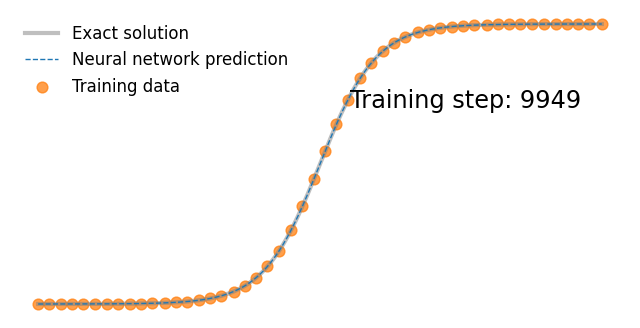

In [15]:
# Plot the final fit
yp_exact = model(x_exact).detach()
plot_result(x_exact[:,0], y_exact[:,0], x_data[:,0], y_data[:,0], yp_exact)

file_nn = "nn_sig_with_%s_%d-%d-%d-%d.png" % (activation().__class__.__name__, scale_ind, shift_ind, scale_dep, shift_dep)
plt.savefig(file_nn, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor='white')

save_gif_PIL("nn_sig_with_%s_%d-%d-%d-%d.gif" % (activation().__class__.__name__, scale_ind, shift_ind, scale_dep, shift_dep), files_nn, fps=gif_fps, loop=0)

display.Image(file_nn)

for name,param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)